In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2

In [2]:
%matplotlib inline

In [3]:
def recolour_image(before, bgr=[1.5, 0.75, 1.25]):
    before = cv2.cvtColor(before, cv2.COLOR_GRAY2BGR)
    b, g, r = cv2.split(before)

    np.multiply(b, bgr[0], out=b, casting="unsafe")
    np.multiply(g, bgr[1], out=g, casting="unsafe")
    np.multiply(r, bgr[2], out=r, casting="unsafe")

    after = cv2.merge([b, g, r])
    
    return after


def split_images(im):
    return im[0], im[int(len(im)/2)]


def overlay_images(img1, img2, translation):
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img_0 = recolour_image(img1, bgr=[0, 0, 255])
    img_180 = np.fliplr(recolour_image(img2, bgr=[0, 255, 0]))
    img_180_shift = cv2.warpAffine(img_180, M, (img_180.shape[1], img_180.shape[0]))
    blended = cv2.addWeighted(img_0, 0.5, img_180_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended


def subtract_images(img1, img2, translation):
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img2 = np.fliplr(img2)
    img_180_shift = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    subtracted = cv2.subtract(img1, img_180_shift)
    
    return subtracted


def misalignment(img1, img2, offset):
    x = subtract_images(img1, img2, offset)
    width = np.shape(x)[1]
    intensity = np.concatenate(x[:,width//4:width*3//4]).sum()
    
    return intensity


def align_images(img1, img2):
    offsets = np.arange(-200, 200)  # TODO: make this proportional to image dimensions
    misalignments = [misalignment(img1, img2, i) for i in offsets]
    stack = np.column_stack((offsets, misalignments))
    optimal = stack[np.argmin(stack[:, 1]), 0]
    
    return optimal


def plot_alignment(im):
    img1, img2 = split_images(im)
    optimal = align_images(img1, img2)
    f, axes = plt.subplots(1,2)
    axes[0].imshow(overlay_images(img1, img2, 0).astype(np.uint8))
    axes[0].set_title('Original')
    axes[1].imshow(overlay_images(img1, img2, optimal).astype(np.uint8))
    axes[1].set_title(f'Aligned (offset {optimal} px)')
    plt.show()

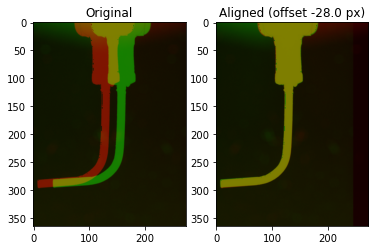

In [4]:
needle_resized = io.imread('../data_store/2022-10-10_1433_testrecon/2022-10-10_1433_testrecon_result.tif')
plot_alignment(needle_resized)

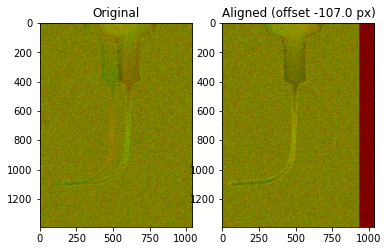

In [5]:
needle_full = io.imread('../data_store/2022-10-10_1433_testrecon/2022-10-10_1433_testrecon.tif')
plot_alignment(needle_full)

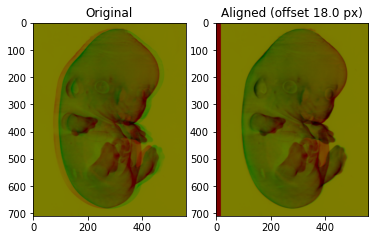

In [6]:
mouse = io.imread('../data_store/MSc_OPT_testdata/misaligned/misaligned.tif')
plot_alignment(mouse)